# Getting Started with Unstructured API and Redis


[Unstructured](https://unstructured.io) is an ETL+ platform for prepping unstructured data for GenAI pipelines. It lets you:

* Connect to common enterprise data systems, including cloud storage (S3, Azure Blob), collaboration tools (Confluence, Dropbox), business apps (Salesforce, Jira, Zendesk), and databases (Databricks, Redis)
* Continuously ingest documents from those sources
* Standardize, enrich, chunk, and embed the content for downstream use
* Push the results into a vector store or database, in this case, **Redis**

You can configure all of this through the Unstructured UI, the API, or directly from Python using their SDK.

This notebook walks through setting up a complete data workflow using the Unstructured API. We’ll pull files from an S3 bucket, process them with a few key transformations, and send the output to Redis, making the data ready to be queried, searched, or integrated into a RAG pipeline.

For source configuration, we’ll use S3 in this example, though you can swap in any supported [data source](https://docs.unstructured.io/api-reference/workflow/sources/overview). The destination will be a Redis instance configured to accept chunks via Unstructured’s [Redis connector](https://docs.unstructured.io/api-reference/workflow/destinations/redis).

This is what the complete data processing pipeline will look like:
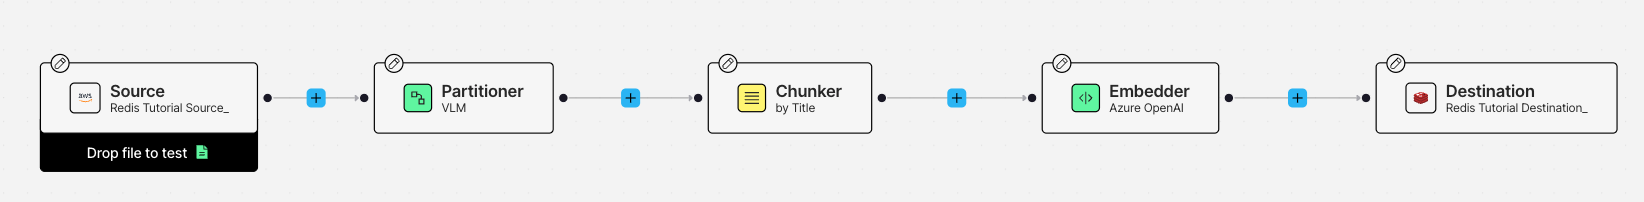


## Prerequisites

Before running this notebook, you’ll need a few things set up so that Unstructured can connect to your source (e.g. S3) and send processed data to Redis.


### Unstructured API Key

Create an API key from the [Unstructured Platform](https://platform.unstructured.io)

1. [Contact us](https://unstructured.io/enterprise) to get access or log in if you're already a user.
2. Once logged in, go to the **API Keys** section in the sidebar.
3. Click **New Key**, name it (e.g. `redis-workflow-key`), and copy it securely.

---

### AWS S3 (Source)

We’ll use S3 to source raw documents.

Make sure you have:

- **AWS Access Key** and **Secret**
- An **S3 bucket URI**, like: `s3://your-bucket/`
- A few files uploaded — PDF, DOCX, HTML, etc. See [supported file types](https://docs.unstructured.io/getting-started/ingest/supported-file-types) for reference.

Store these credentials securely in your notebook or environment variables.

---

### Redis (Destination)

You’ll need access to a Redis instance. This can be hosted on Redis Cloud or self-managed.

Required connection details:

- **Hostname**
- **Port**
- **Username** (optional — depending on your setup)
- **Password**
- **Database number** (commonly `0`)

If you’re using Redis Cloud, you can find these under your instance’s connection settings. Ensure your client can reach the Redis endpoint (some Redis setups restrict IPs or require SSL).

You can also customize:

- `batch_size`: controls how many documents are sent per write operation
- `ssl`: enable if using a secure connection

For a full list of available options, see the [Redis destination documentation](https://docs.unstructured.io/api-reference/workflow/destinations/redis).



## Step 1: Install the Unstructured API Python SDK

All functionality available in the the UI of the [Unstructured](https://unstructured.io/) product is also available programmatically via Unstructured API. You can interact with Unstructured API either by sending direct requests via curl or postman, or using Unstructured API [Python SDK](https://docs.unstructured.io/api-reference/workflow/overview#unstructured-python-sdk). Here, we'll be using the latter.


> **Note:**
The Unstructured API has two endpoints:
* The Unstructured Partition Endpoint: intended for rapid prototyping of Unstructured's various partitioning strategies. It works only with processing of local files, one file at a time.
* The Unstructured Workflow Endpoint: enables a full range of partitioning, chunking, embedding, and enrichment options for your data. It is designed to batch-process data from any data source to any destination. This is what we're using in this notebook.


Run the following cell to install the Unstructured API Python SDK.

In [ ]:
!pip install -U "unstructured-client"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 15.4 MB/s eta 0:00:00


## Step 2: Set environment variables

Fetching the values from Colab Secrets!

In [ ]:
import os
from google.colab import userdata

# Unstructured
os.environ['UNSTRUCTURED_API_KEY'] = userdata.get('UNSTRUCTURED_API_KEY')

# AWS S3
os.environ['AWS_ACCESS'] = userdata.get('AWS_ACCESS')
os.environ['AWS_SECRET'] = userdata.get('AWS_SECRET')
os.environ['S3_REMOTE_URL'] = userdata.get('S3_REMOTE_URL')


# Redis Cloud
os.environ['REDIS_DATABASE_NAME'] = userdata.get('REDIS_DATABASE_NAME')
os.environ['REDIS_HOSTNAME'] = userdata.get('REDIS_HOSTNAME')
os.environ['REDIS_PORTNUMBER'] = userdata.get('REDIS_PORTNUMBER')
os.environ['REDIS_USERNAME'] = userdata.get('REDIS_USERNAME')
os.environ['REDIS_PASSWORD'] = userdata.get('REDIS_PASSWORD')
os.environ['REDIS_DATABASE_NUMBER'] = userdata.get('REDIS_DATABASE_NUMBER')




In [ ]:
# instantiate Unstructured Client
from unstructured_client import UnstructuredClient

unstructured_client = UnstructuredClient(api_key_auth=os.environ["UNSTRUCTURED_API_KEY"])

# helper function
def pretty_print_model(response_model):
    print(response_model.model_dump_json(indent=4))

## Step 3: Create the source connector

Run the following cell to create an [AWS S3 source connector](https://docs.unstructured.io/api-reference/workflow/sources/s3).

When setting up a source connector, you'll need to:
- Give it a unique name.
- Specify its type (`s3` in this case).
- Provide configuration details including your S3 location and credentials.

Your configuration must include:
- `remote_url`: the URI to your S3 bucket or folder (e.g. `s3://my-bucket/data/`)
- `key`: your AWS access key
- `secret`: your AWS secret key
- `recursive`: (optional) whether to include files in subfolders

In [ ]:
from unstructured_client.models.operations import CreateSourceRequest
from unstructured_client.models.shared import CreateSourceConnector

source_response = unstructured_client.sources.create_source(
    request=CreateSourceRequest(
        create_source_connector=CreateSourceConnector(
            name=f"Redis Tutorial Source_",
            type="s3",
            config={
              "key": os.environ.get('AWS_ACCESS'),
              "secret": os.environ.get('AWS_SECRET'),
              "remote_url": os.environ.get('S3_REMOTE_URL'),
              "recursive": True
            }
        )
    )
)

pretty_print_model(source_response.source_connector_information)

{
    "config": {
        "anonymous": false,
        "recursive": true,
        "remote_url": "s3://ajay-uns-devrel-content/agentic-analysis/",
        "key": "**********",
        "secret": "**********"
    },
    "created_at": "2025-08-06T14:30:48.002626Z",
    "id": "c7c6e187-35fe-4a0f-be8d-2f37ed3744ba",
    "name": "Redis Tutorial Source_",
    "type": "s3",
    "updated_at": "2025-08-06T14:30:48.181506Z"
}


## Step 4: Create the destination connector

Now that your Redis credentials are available as environment variables, you're ready to create the destination connector.

This step defines the **Redis destination**, specifying:
- A unique connector name
- The connector type (`redis`)
- Required connection parameters:
  - `host`: Redis hostname (e.g. from Redis Cloud)
  - `port`: connection port (default is usually 6379 or your Redis Cloud port)
  - `username` and `password`: for authentication (Redis Cloud requires both)
  - `database`: Redis logical database index (default is `0`)
  - `ssl`: whether to use SSL for the connection (set to `True` for secure endpoints)
  - `batch_size`: how many documents to push in each write operation

These values are pulled from environment variables






In [ ]:
from unstructured_client.models.operations import CreateDestinationRequest
from unstructured_client.models.shared import CreateDestinationConnector

destination_response = unstructured_client.destinations.create_destination(
    request=CreateDestinationRequest(
        create_destination_connector=CreateDestinationConnector(
            name="Redis Tutorial Destination_",
            type="redis",
            config={
                "database": os.environ.get("REDIS_DATABASE_NUMBER"),
                "ssl": False,
                "batch_size": 100,

                # For password authentication:
                "host": os.environ.get("REDIS_HOSTNAME"),
                "port": os.environ.get("REDIS_PORTNUMBER"),
                "username": os.environ.get("REDIS_USERNAME"),
                "password": os.environ.get("REDIS_PASSWORD")
            }
        )
    )
)

pretty_print_model(destination_response.destination_connector_information)

{
    "config": {
        "batch_size": 100,
        "database": 0,
        "host": "redis-15786.c93.us-east-1-3.ec2.redns.redis-cloud.com",
        "port": 15786,
        "ssl": false,
        "password": "**********",
        "username": "default"
    },
    "created_at": "2025-08-06T14:30:48.527175Z",
    "id": "697f180a-53af-454d-9cd9-4cfe6a03a623",
    "name": "Redis Tutorial Destination_",
    "type": "redis",
    "updated_at": "2025-08-06T14:30:48.609871Z"
}


## Step 5: Create the data processing workflow

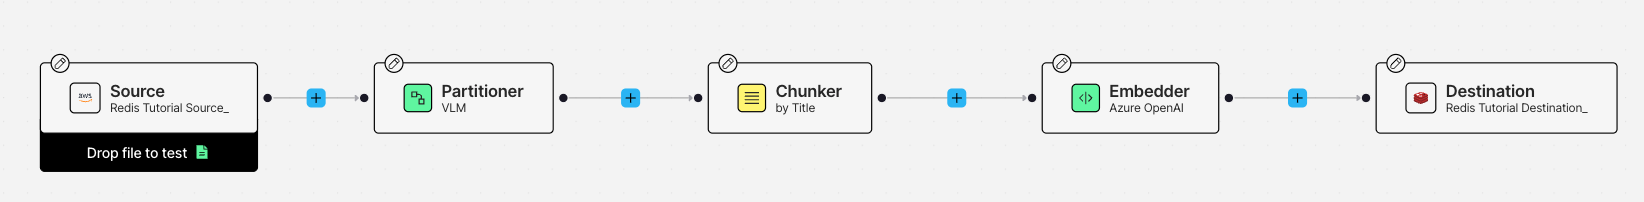


Here’s where we define how documents move from source to destination. A workflow is just a chain of processing steps — each one represented by a `WorkflowNode`.

In this setup, we’re using three nodes: `partition`, `chunk`, and `embed`.


### 🧩 Partition

This always comes first. It takes in raw files — PDFs, Word docs, HTML — and turns them into structured JSON with metadata. We’re using the `vlm` strategy here, backed by Anthropic’s Claude Sonnet 4.5, which works well for layout-heavy or noisy documents.

→ [How partitioning works](https://docs.unstructured.io/api-reference/partition/document-elements)



### ✂️ Chunk

Next, we split that structured content into smaller chunks. This helps with retrieval later and keeps us under model token limits. The `chunk_by_title` strategy breaks things up based on document headers, with character limits and overlap settings for better continuity.

→ [Chunking strategies explained](https://docs.unstructured.io/ui/chunking)



### 📐 Embed

Last step: embedding. Each chunk gets turned into a dense vector using Azure OpenAI’s `text-embedding-3-large`. These vectors are what we’ll send to Redis for downstream search or RAG.

→ [Embedding models and config](https://docs.unstructured.io/ui/embedding)


All three nodes are passed into `create_workflow`, which registers the DAG and ties everything together: from S3 input all the way to Redis.


In [ ]:
from unstructured_client.models.shared import (
    WorkflowNode,
    WorkflowType,
    Schedule
)

parition_node = WorkflowNode(
    name="Partitioner",
    subtype="vlm",
    type="partition",
    settings={
        "provider": "anthropic",
        "model": "claude-sonnet-4-5-20250929",
        }
    )

chunk_node = WorkflowNode(
    name="Chunker",
    subtype="chunk_by_title",
    type="chunk",
    settings={
        "new_after_n_chars": 1000,
        "max_characters": 4096,
        "overlap": 150
    }
)

embedder_node = WorkflowNode(
    name='Embedder',
    subtype='azure_openai',
    type="embed",
    settings={
        'model_name': 'text-embedding-3-large'
        }
    )


response = unstructured_client.workflows.create_workflow(
    request={
        "create_workflow": {
            "name": f"Redis Tutorial Workflow_",
            "source_id": source_response.source_connector_information.id,
            "destination_id": destination_response.destination_connector_information.id,
            "workflow_type": WorkflowType.CUSTOM,
            "workflow_nodes": [
                parition_node,
                chunk_node,
                embedder_node
            ]
        }
    }
)

pretty_print_model(response.workflow_information)
workflow_id = response.workflow_information.id

## Step 6: Run the workflow

Run the following cell to start running the workflow.

In [ ]:
res = unstructured_client.workflows.run_workflow(
    request={
        "workflow_id": workflow_id,
    }
)

pretty_print_model(res.job_information)

{
    "created_at": "2025-07-12T15:09:12.501570Z",
    "id": "38a93dc7-67bf-43b6-bea4-7c9a5ce212d6",
    "status": "SCHEDULED",
    "workflow_id": "0d9bc496-44cb-4bac-8302-bd0438fd58da",
    "workflow_name": "Redis Tutorial Workflow_",
    "job_type": "ephemeral"
}


## Step 7: Get the workflow run's job ID

Run the following cell to get the workflow run's job ID, which is needed to poll for job completion later. If successful, Unstructured prints the job's ID.

In [ ]:
response = unstructured_client.jobs.list_jobs(
    request={
        "workflow_id": workflow_id
    }
)

last_job = response.response_list_jobs[0]
job_id = last_job.id
print(f"job_id: {job_id}")

job_id: 38a93dc7-67bf-43b6-bea4-7c9a5ce212d6


## Step 8: Poll for job completion

Run the following cell to confirm the job has finished running. If successful, Unstructured prints `"status": "COMPLETED"` within the information about the job.

In [ ]:
import time

def poll_job_status(job_id, wait_time=30):
    while True:
        response = unstructured_client.jobs.get_job(
            request={
                "job_id": job_id
            }
        )

        job = response.job_information

        if job.status == "SCHEDULED":
            print(f"Job is scheduled, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        elif job.status == "IN_PROGRESS":
            print(f"Job is in progress, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print("Job is completed")
            break

    return job

job = poll_job_status(job_id)
pretty_print_model(job)

Job is scheduled, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is completed
{
    "created_at": "2025-07-12T15:09:12.501570",
    "id": "38a93dc7-67bf-43b6-bea4-7c9a5ce212d6",
    "status": "COMPLETED",
    "workflow_id": "0d9bc496-44cb-4bac-8302-bd0438fd58da",
    "workflow_name": "Redis Tutorial Workflow_",
    "job_type": "ephemeral",
    "runtime": "PT0S"
}


## Step 9: View the processed data

Once the job finishes, your documents will be processed and stored in Redis as key-value pairs — one key per chunk. Each value holds the structured JSON output, ready to be retrieved for semantic search or downstream use.

You can open Redis Insight to browse and inspect the inserted data directly.


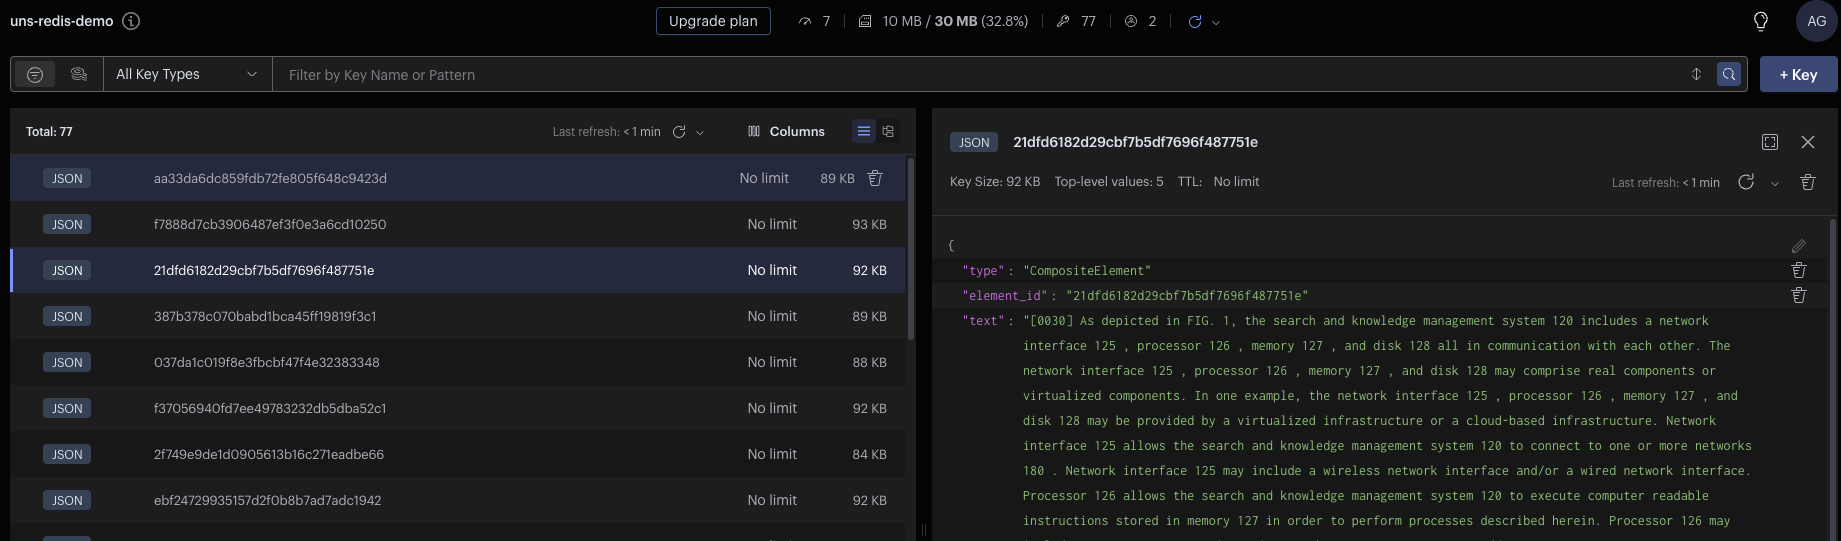